In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import torch
import torch.nn as nn
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BaseRNN(nn.Module):
    def __init__(self, rnn_layer, input_size, hidden_size=50):
        super(BaseRNN, self).__init__()
        self.rnn = rnn_layer(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # regression output

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out



# SimpleRNN
class RNNModel(BaseRNN):
    def __init__(self, input_size, hidden_size=50):
        super().__init__(nn.RNN, input_size, hidden_size)


# LSTM
class LSTMModel(BaseRNN):
    def __init__(self, input_size, hidden_size=50):
        super().__init__(nn.LSTM, input_size, hidden_size)


# GRU
class GRUModel(BaseRNN):
    def __init__(self, input_size, hidden_size=50):
        super().__init__(nn.GRU, input_size, hidden_size)


# BiLSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # *2 because bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]     # last time step
        out = self.fc(out)
        return out

In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


In [ ]:
def return_pairs(column, days):
    """
    Create supervised learning dataset from time series data
    """
    prices = list(column)
    X = []
    y = []
    for i in range(len(prices) - days):
        X.append(prices[i:i+days])
        y.append(prices[i+days])
    return np.array(X), np.array(y)

# Define target column and time windows for assignment
target_column = 'High'
time_windows = [30, 60, 90]

print(f"Target column: {target_column}")
print(f"Time windows: {time_windows}")

Target column: High
Time windows: [30, 60, 90]


In [ ]:
scaler = StandardScaler()
df2 = df.copy()
df2['High'] = scaler.fit_transform(df[['High']])
chunked_data = {}

for days in time_windows:
    key_X = f"X_{target_column}_{days}"
    key_y = f"y_{target_column}_{days}"
    X, y = return_pairs(df2[target_column], days)
    chunked_data[key_X] = X
    chunked_data[key_y] = y
    print(f"Created {key_X}: {X.shape}, {key_y}: {y.shape}")

chunk_pairs = []
for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

print(f"\nTotal data pairs created: {len(chunk_pairs)}")

Created X_High_30: (6285, 30), y_High_30: (6285,)
Created X_High_60: (6255, 60), y_High_60: (6255,)
Created X_High_90: (6225, 90), y_High_90: (6225,)

Total data pairs created: 3


In [ ]:
ml_models = [('KNN', KNeighborsRegressor())]

# 2) DL builders (PyTorch)

dl_models = {
    'RNN':       lambda input_size: RNNModel(input_size=input_size, hidden_size=50),
    'LSTM':      lambda input_size: LSTMModel(input_size=input_size, hidden_size=50),
    'GRU':       lambda input_size: GRUModel(input_size=input_size, hidden_size=50),
    'BiLSTM':    lambda input_size: BiLSTMModel(input_size=input_size, hidden_size=50),
}

In [ ]:
## Training Loop
def train_torch_model(model, X_train, y_train, epochs=10, batch_size=8, lr=1e-3):
    """
    X_train: numpy array (N, seq_len, 1)
    y_train: numpy array (N,)
    """
    model = model.to(device)
    model.train()

    X_t = torch.from_numpy(X_train).float().to(device)
    y_t = torch.from_numpy(y_train).float().unsqueeze(1).to(device)

    ds = TensorDataset(X_t, y_t)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for _ in range(epochs):
        for xb, yb in dl:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    return model


In [ ]:
## Prediction
def torch_predict(model, X):
    """
    X: numpy array (N, seq_len, 1)
    returns: numpy array (N,)
    """
    model.eval()
    X_t = torch.from_numpy(X).float().to(device)
    preds = model(X_t).cpu().detach().numpy().reshape(-1)
    return preds

In [ ]:
trained_models = {}

for X_key, y_key in tqdm(chunk_pairs):
    X_data = chunked_data[X_key]     # shape: (N, days)
    y_data = chunked_data[y_key]     # shape: (N,)

    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # -------------------- KNN --------------------
    for model_name, model in tqdm(ml_models, leave=False):
        key = model_name + '_' + X_key[2:]

        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred  = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        }


    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn  = np.expand_dims(X_test,  -1)

    seq_len = X_train_rnn.shape[1]
    input_size = 1

    for model_name, builder in tqdm(dl_models.items(), leave=False):
        key = model_name + '_' + X_key[2:]

        model_dl = builder(input_size)

        # train
        model_dl = train_torch_model(
            model_dl, X_train_rnn, y_train,
            epochs=10, batch_size=8, lr=1e-3
        )

        # predict
        y_train_pred = torch_predict(model_dl, X_train_rnn)
        y_test_pred  = torch_predict(model_dl, X_test_rnn)

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        }

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df = results_df.sort_values(by='test_mae', ascending=True)

print("Results for High Price Prediction:")
print("=" * 50)
print(results_df[['Model', 'train_mae', 'test_mae', 'train_rmse', 'test_rmse']].round(4))

Results for High Price Prediction:
             Model  train_mae  test_mae  train_rmse  test_rmse
10     KNN_High_90     0.0059    0.0078      0.0094     0.0118
5      KNN_High_60     0.0059    0.0084      0.0093     0.0132
0      KNN_High_30     0.0068    0.0091      0.0110     0.0143
8      GRU_High_60     0.0098    0.0093      0.0154     0.0148
14  BiLSTM_High_90     0.0097    0.0097      0.0152     0.0148
3      GRU_High_30     0.0124    0.0115      0.0184     0.0171
7     LSTM_High_60     0.0128    0.0123      0.0182     0.0179
12    LSTM_High_90     0.0121    0.0123      0.0176     0.0171
11     RNN_High_90     0.0130    0.0123      0.0170     0.0169
4   BiLSTM_High_30     0.0136    0.0134      0.0197     0.0201
2     LSTM_High_30     0.0138    0.0142      0.0189     0.0197
1      RNN_High_30     0.0161    0.0148      0.0241     0.0220
9   BiLSTM_High_60     0.0160    0.0157      0.0202     0.0193
13     GRU_High_90     0.0168    0.0166      0.0218     0.0219
6      RNN_High_60  

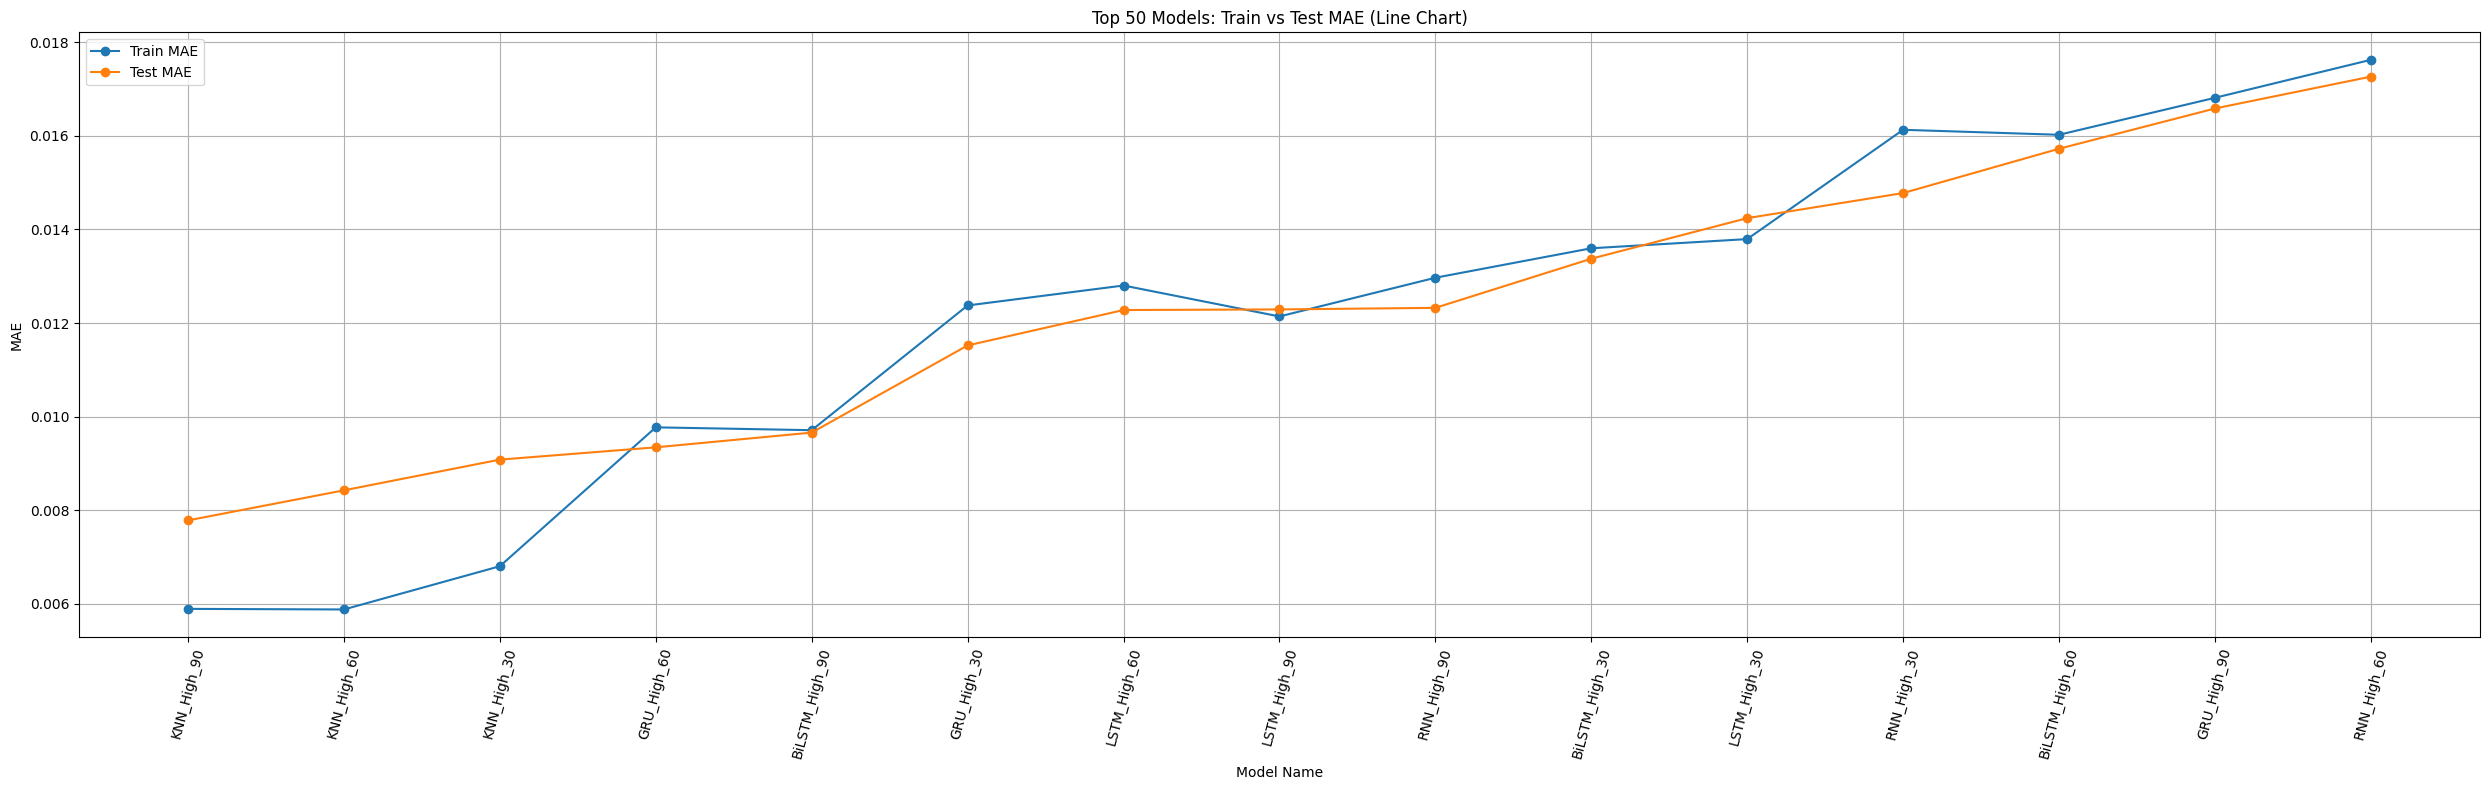

In [ ]:
import matplotlib.pyplot as plt


top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)

plt.figure(figsize=(25, 8))
plt.plot(top_50['Model'], top_50['train_mae'], marker='o', label='Train MAE')

plt.plot(top_50['Model'], top_50['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Top 50 Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

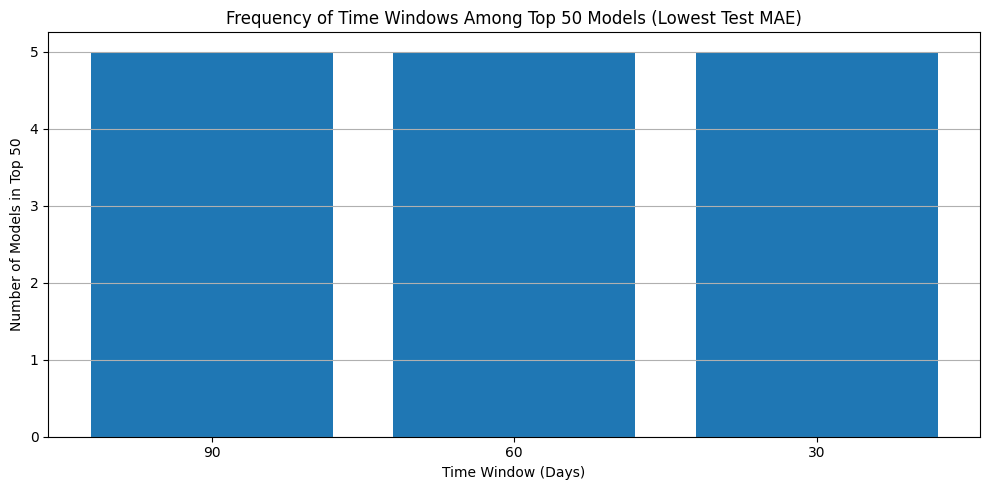

In [ ]:
# Extract time windows from top 50 models
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
time_windows = pd.Series([i.split('_')[-1] for i in top_50['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

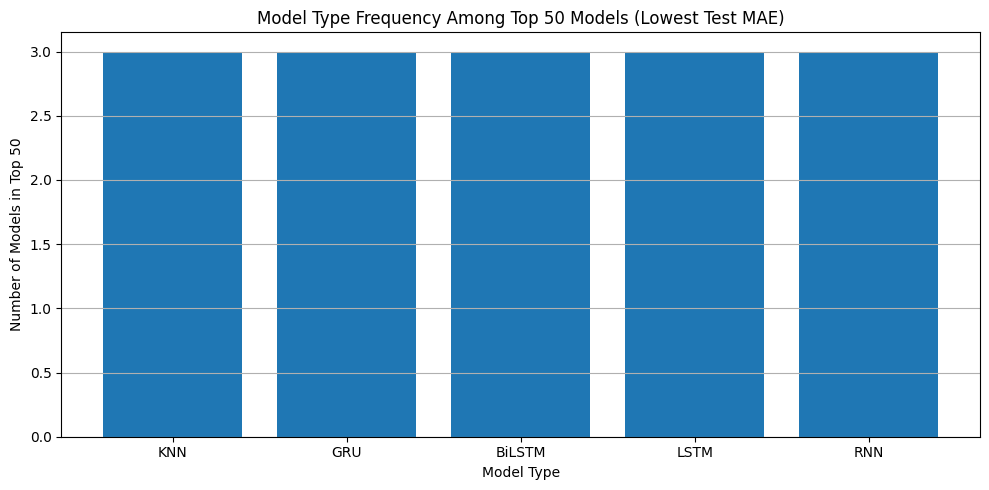

In [ ]:
# Extract model types from top 50 models
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
model_types = pd.Series([i.split('_')[0] for i in top_50['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
